# Installation

These models are loaded from torch hub, and can be used as pretrained models in your own applications.

For setup process and requirement please follow the instructions in <a herf="https://github.com/TRI-ML/vidar">here</a>

we are going to use some of the utils from the vidar to visualize the results. So we added the edited version of the vidar to work with ARKitScenes dataset. You can find this package with its instructions under : `models/vidar`

In [ ]:
import torch
from skimage.io import imread
import numpy as np
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import pandas as pd
import os
# path to the vidar module  
import sys
sys.path.append('../../../')
from models.vidar.vidar.utils.write import *
from models.vidar.vidar.utils.viz import *
from models.vidar.vidar.utils.read import *

print("Is cuda available: ", torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

In [2]:
ARKITScenesDataSet = "/workspace/vidar_release/dataset/upsampling"
NYUDataset = "/workspace/vidar_release/dataset/NYU"
validation_path = os.path.join(ARKITScenesDataSet, 'Validation')

print("ArkitScene dataset path: ", ARKITScenesDataSet)
print("NYU dataset path: ", NYUDataset)

ArkitScene dataset path:  /workspace/vidar_release/dataset/upsampling
NYU dataset path:  /workspace/vidar_release/dataset/NYU


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Selected Device:', device)

Selected Device: cuda


In [18]:
def load_model(name):
    return torch.hub.load("TRI-ML/vidar", name, pretrained=True, trust_repo=True)

In [ ]:
model = load_model('ZeroDepth')
# model = load_model('PackNet')
model = model.to(device)

### Functions


In [7]:
def read_intrinsics(file):
    with open("models/vidar/examples/arkitscenes_sample.pincam", "r") as f:
        intrinsics = f.read().split()[2:]
        intrinsics = [float(i) for i in intrinsics]
    
        # build camera matrix in tensor
        K = torch.tensor([[intrinsics[0], 0, intrinsics[2]],
                            [0, intrinsics[1], intrinsics[3]],
                            [0, 0, 1]])
        K = K.reshape(1,3,3)
    return K

def read_images(lowres_img_path, lowres_depth_path, downsampled_GT_depth):
    if lowres_depth_path !=" ":
        lowres_depth = cv2.imread(lowres_depth_path, cv2.IMREAD_ANYDEPTH)
        lowres_depth = lowres_depth.astype(np.float32) / 1000.0
        loweres_depth = None
    downsampled_GT_depth = cv2.imread(downsampled_GT_depth, cv2.IMREAD_ANYDEPTH)
    downsampled_GT_depth = downsampled_GT_depth.astype(np.float32) / 1000.0
    lowres_img = torch.tensor(cv2.imread(lowres_img_path)).permute(2,0,1).unsqueeze(0)/255.
    lowres_img = lowres_img.to(device)
    
    # convert to tensor
    if lowres_depth_path !=" ":
        lowres_depth = torch.from_numpy(lowres_depth).float()
        lowres_depth = lowres_depth.unsqueeze(0).unsqueeze(0)
        lowres_depth = lowres_depth.to(device)
    downsampled_GT_depth = torch.from_numpy(downsampled_GT_depth).float()
    downsampled_GT_depth = downsampled_GT_depth.unsqueeze(0).unsqueeze(0)
    downsampled_GT_depth = downsampled_GT_depth.to(device)
    
    return lowres_img, lowres_depth, downsampled_GT_depth


def read_gt(file='examples/gt.png'):
    gt_depth = cv2.imread(file, cv2.IMREAD_ANYDEPTH)
    gt_depth = gt_depth.astype(np.float32) / 1000.0
    # convert gt_depth to tensor
    gt_depth = torch.from_numpy(gt_depth).float()
    gt_depth = gt_depth.unsqueeze(0).unsqueeze(0)
    gt_depth = gt_depth.to(device)
    return gt_depth

def compute_errors(gt_depth, pred_depth):
    # Interpolating to the same size
    gt_depth = F.interpolate(gt_depth, pred_depth.shape[2:], mode='nearest')

    # Creating a mask of valid ground truth depth values (not equal to zero)
    mask = gt_depth > 0

    # Applying the mask to both ground truth and predicted depths
    gt_depth = gt_depth[mask]
    pred_depth = pred_depth[mask]

    # Thresholding
    thresh = torch.max(gt_depth / pred_depth, pred_depth / gt_depth)
    a1 = (thresh < 1.25).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    # Errors
    rmse = torch.sqrt(((gt_depth - pred_depth) ** 2).mean())
    rmse_log = torch.sqrt(((torch.log(gt_depth) - torch.log(pred_depth)) ** 2).mean())
    abs_rel = (torch.abs(gt_depth - pred_depth) / gt_depth).mean()
    rel = abs_rel # Relative error, which might be the same as abs_rel in this context

    return abs_rel, rmse, rmse_log, a1, a2, a3, rel



## Read Data


In [8]:
input_img = torch.tensor(cv2.imread('models/vidar/examples/arkitscenes_sample.png')).permute(2,0,1).unsqueeze(0)/255.
gt_depth = read_gt('examples/gt.png')

### Camera intrinsics Matrix:

```
intrinsics = [
        [fx, 0, ox],
        [0, fy, oy],
        [0, 0, 1]
        ]
```

`.pincam` - store the intrinsic matrix for each RGB image is a single-line text file, space-delimited, with the following fields:

`width height focal_length_x focal_length_y principal_point_x principal_point_y`


In [9]:
K = read_intrinsics('models/vidar/examples/arkitscenes_sample.pincam')
print(K)

tensor([[[213.5940,   0.0000, 124.8730],
         [  0.0000, 213.5940,  94.6147],
         [  0.0000,   0.0000,   1.0000]]])


In [10]:
input_img = input_img.to(device)
K = K.to(device)

### Perform inference with the model

In [11]:
with torch.no_grad():
    depth_pred = model(input_img, K)

if type(depth_pred) == list: # only for packnet 
    depth_pred = depth_pred[0]

print(depth_pred.shape)

torch.Size([1, 1, 192, 256])


### Visualize

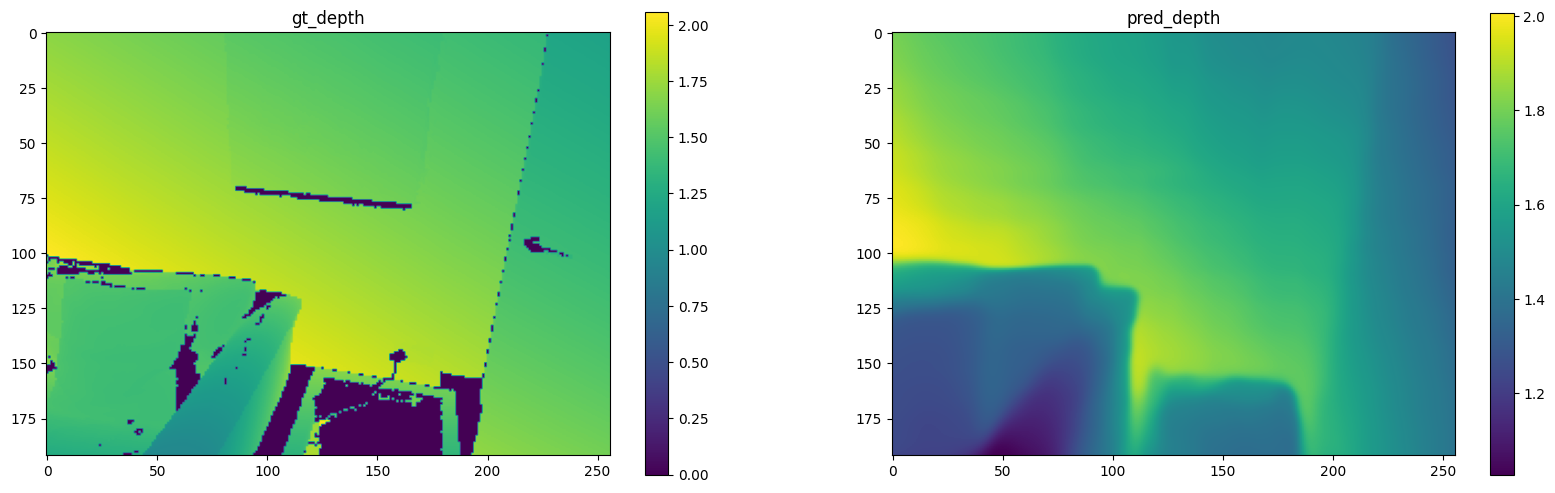

In [12]:
# visualize the gt_depth and pred_depth

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(gt_depth.cpu()[0, 0, :, :])
plt.title('gt_depth')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(depth_pred.cpu()[0, 0, :, :])
plt.title('pred_depth')
plt.colorbar()
plt.show()


### Calculate Errors

In [13]:
abs_rel, rmse, rmse_log, a1, a2, a3, rel = compute_errors(gt_depth, depth_pred)

print("Absolute Relative Error:", abs_rel.item())
print("Relative Error:", rel.item())
print("Root Mean Squared Error:", rmse.item())
print("Root Mean Squared Error (Log):", rmse_log.item())
print("Thresholded Accuracy a1:", a1.item())
print("Thresholded Accuracy a2:", a2.item())
print("Thresholded Accuracy a3:", a3.item())


Absolute Relative Error: 0.03967919945716858
Relative Error: 0.03967919945716858
Root Mean Squared Error: 0.07968491315841675
Root Mean Squared Error (Log): 0.05499224364757538
Thresholded Accuracy a1: 0.9971961975097656
Thresholded Accuracy a2: 1.0
Thresholded Accuracy a3: 1.0


## Testing on ARkitScenes Validation Set

In [ ]:
# write to csv
with open('../../results/ZeroDepth(Vidar)/csv/stats_results_ZeroDepth.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["frame_id", "RMSE", "RMSE_arkit", "REL", "REL_arkit"])

for sample_id in os.listdir(validation_path):
    for file in os.listdir(os.path.join(validation_path, sample_id, 'lowres_wide')):
        lowres_img, arkit_depth, gt_depth = read_images(os.path.join(validation_path, sample_id, 'lowres_wide', file),
                                                        os.path.join(validation_path, sample_id, 'lowres_depth', file),
                                                        os.path.join(validation_path, sample_id, 'downsampled_gt', file))
        
        k = read_intrinsics(os.path.join(validation_path, sample_id, 'lowres_wide_intrinsics', file.replace('.png', '.pincam')))
        k = k.to(device)
        lowres_img = lowres_img.to(device)
        # prediction
        with torch.no_grad():
            depth_pred = model(input_img, k)
        if type(depth_pred) == list: # only for packnet 
            depth_pred = depth_pred[0]
            
        abs_rel, rmse, rmse_log, a1, a2, a3, rel = compute_errors(gt_depth, depth_pred)
        abs_rel_arkit, rmse_arkit, rmse_log_arkit, a1_arkit, a2_arkit, a3_arkit, rel_arkit = compute_errors(gt_depth, arkit_depth)
        # write to csv
        with open('../../results/stats_results_ZeroDepth.csv', 'a') as f:
            writer = csv.writer(f)
            writer.writerow([file, rmse.item(), rmse_arkit.item(), rel.item(), rel_arkit.item()])



## Draw Charts

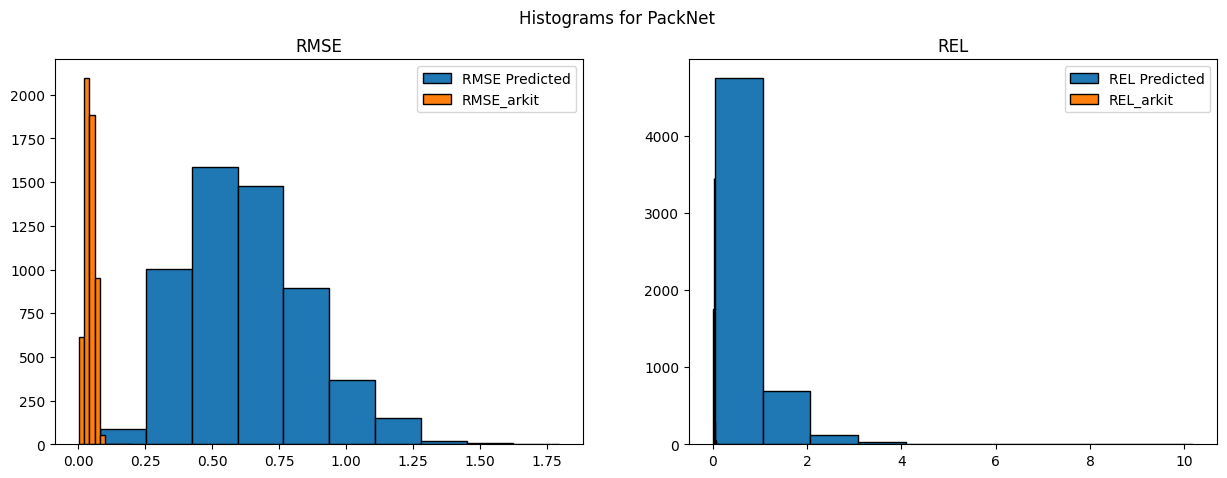

In [16]:
# read csv
df = pd.read_csv('../../results/stats_results_ZeroDepth.csv')
df.head()

# plot histograms for RMSE_Trained and REL_Trained
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df['RMSE'], edgecolor='black', label='RMSE Predicted')
ax[0].hist(df['RMSE_arkit'], edgecolor='black', label='RMSE_arkit')
ax[0].set_title('RMSE')
ax[0].legend()

ax[1].hist(df['REL'], edgecolor='black', label='REL Predicted')
ax[1].hist(df['REL_arkit'], edgecolor='black', label='REL_arkit')
ax[1].set_title('REL')
ax[1].legend()

fig.suptitle('Histograms for PackNet')

plt.savefig('../../results/histograms_PackNet.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [18]:
df.describe()

,RMSE,RMSE_arkit,REL,REL_arkit
count,5598.000000,5598.000000,5598.000000,5598.000000
mean,0.629081,0.043221,0.616858,0.021046
std,0.227111,0.017425,0.557429,0.007748
min,0.079552,0.001974,0.039342,0.003843
25%,0.456310,0.029971,0.259972,0.016698
50%,0.603394,0.042216,0.424449,0.019729
75%,0.771542,0.056683,0.783829,0.023642
max,1.794697,0.199606,10.190228,0.140808
